# I. Total row, features.

In [1]:
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import BlipProcessor, BlipForConditionalGeneration, Trainer, TrainingArguments
from datasets import load_dataset,IterableDataset
from itertools import islice
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
dataset = load_dataset("none-yet/anime-captions", split="train", streaming=True)


2025-09-23 14:19:53.530999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758637193.721371      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758637193.776347      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


README.md:   0%|          | 0.00/391 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/57 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/57 [00:00<?, ?it/s]

In [2]:
print("Features:", dataset.features)

Features: {'image': Image(mode=None, decode=True, id=None), 'text': Value(dtype='string', id=None)}


In [3]:
count = sum(1 for _ in dataset)
print("Total samples:", count)

Total samples: 337038


# II. Histogram of caption lengh, n-gram common words.

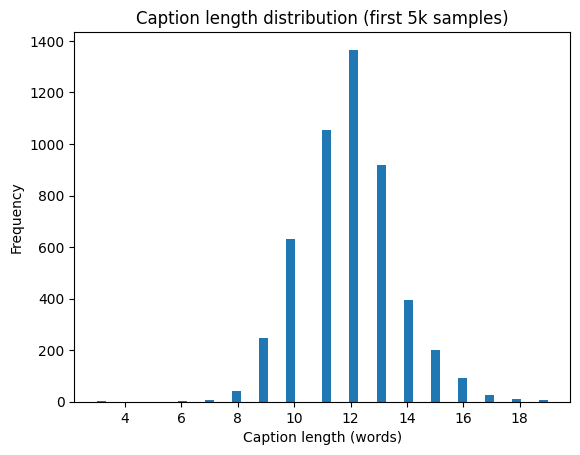

Most common words: [('a', 10443), ('with', 3649), ('anime', 3088), ('and', 2936), ('in', 2779), ('of', 2364), ('girl', 2285), ('on', 1259), ('hair', 1128), ('woman', 987), ('dress', 801), ('holding', 716), ('sitting', 714), ('cartoon', 655), ('picture', 618), ('white', 617), ('characters', 612), ('blue', 572), ('the', 571), ('her', 558)]


In [4]:
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt

caption_lengths = []
word_counter = Counter()

for i, sample in enumerate(dataset):
    text = sample["text"]
    words = text.split()
    caption_lengths.append(len(words))
    word_counter.update(words)

    if i == 5000:  # limit to first 5k samples for speed
        break

# Caption length distribution
plt.hist(caption_lengths, bins=50)
plt.xlabel("Caption length (words)")
plt.ylabel("Frequency")
plt.title("Caption length distribution (first 5k samples)")
plt.show()

# Most common words
print("Most common words:", word_counter.most_common(20))

In [5]:
from datasets import load_dataset
from collections import Counter
import re

def tokenize(text):
    # Lowercase, remove punctuation, split by spaces
    return re.findall(r"\b\w+\b", text.lower())
    
word_counter = Counter()
bigram_counter = Counter()
trigram_counter = Counter()


for i, sample in enumerate(dataset):
    tokens = tokenize(sample["text"])
    word_counter.update(tokens)
    
    # Bigrams
    bigrams = zip(tokens, tokens[1:])
    bigram_counter.update(bigrams)
    
    # Trigrams
    trigrams = zip(tokens, tokens[1:], tokens[2:])
    trigram_counter.update(trigrams)

    if i == 10000:  # limit for speed
        break

print("\nTop 20 words:")
for word, freq in word_counter.most_common(20):
    print(f"{word}: {freq}")

print("\nTop 20 bigrams:")
for bigram, freq in bigram_counter.most_common(20):
    print(f"{' '.join(bigram)}: {freq}")

print("\nTop 20 trigrams:")
for trigram, freq in trigram_counter.most_common(20):
    print(f"{' '.join(trigram)}: {freq}")



Top 20 words:
a: 20753
with: 7345
anime: 6227
and: 5940
in: 5528
of: 4644
girl: 4630
on: 2509
hair: 2271
woman: 1981
dress: 1593
holding: 1459
sitting: 1389
cartoon: 1291
characters: 1200
picture: 1194
white: 1193
blue: 1186
her: 1160
the: 1141

Top 20 bigrams:
with a: 3901
anime girl: 3676
of a: 3492
and a: 3164
in a: 3000
girl with: 2515
a woman: 1899
hair and: 1744
holding a: 1352
on a: 1267
girl in: 1206
sitting on: 1201
a cartoon: 1188
anime characters: 1117
woman in: 1001
with long: 959
a close: 844
close up: 844
up of: 844
picture of: 767

Top 20 trigrams:
anime girl with: 2127
of a woman: 1014
a woman in: 966
woman in a: 965
anime girl in: 956
a close up: 844
close up of: 844
up of a: 834
girl in a: 825
sitting on a: 807
hair and a: 762
girl with long: 713
picture of a: 701
girl with a: 666
drawing of a: 544
strip with a: 521
with long hair: 515
in front of: 477
comic strip with: 458
of a person: 456


# III Verify image sizes & aspect ratios, display random samples, 

In [6]:
sizes = []
ratios = []

for i, sample in enumerate(dataset):
    img: Image.Image = sample["image"]
    w, h = img.size
    sizes.append((w, h))
    ratios.append(round(w / h, 2))

    if i == 5000:  # limit for speed
        break

print("Unique sizes found:", set(sizes))
print("Unique aspect ratios:", set(ratios))

Unique sizes found: {(512, 512)}
Unique aspect ratios: {1.0}


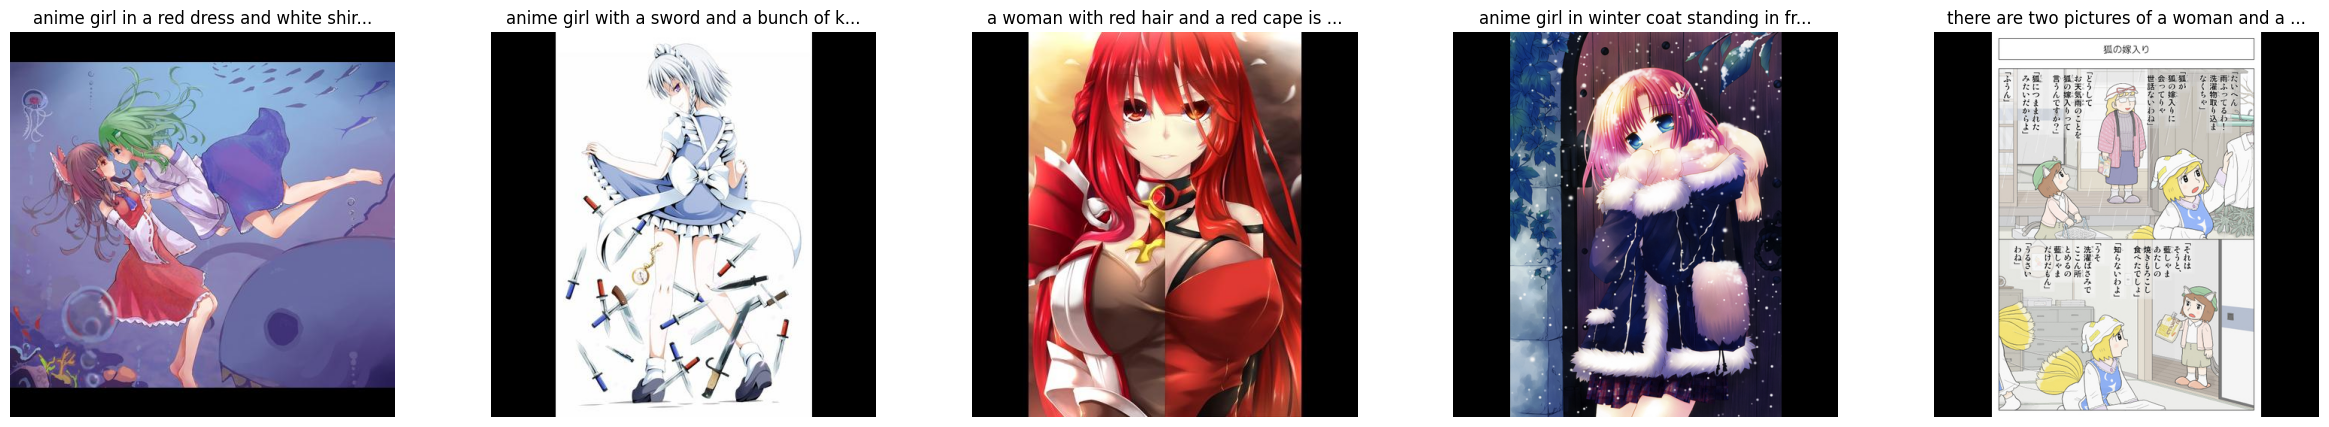

In [7]:
import random


samples = []
for i, sample in enumerate(dataset):
    if random.random() < 0.001:  # random sampling ~0.1%
        samples.append(sample)
    if len(samples) == 5:
        break

# Plot them
fig, axes = plt.subplots(1, len(samples), figsize=(30, 5))
for ax, sample in zip(axes, samples):
    ax.imshow(sample["image"])
    ax.set_title(sample["text"][:40] + "...")
    ax.axis("off")
plt.show()

# IV Check for duplicates or corrupt files

In [12]:
hashes = set()
dupes = 0
corrupt = 0

for i, sample in enumerate(dataset):
    try:
        img = sample["image"]
        # Hash image bytes
        h = hashlib.md5(img.tobytes()).hexdigest()
        if h in hashes:
            dupes += 1
        else:
            hashes.add(h)
    except Exception as e:
        corrupt += 1
    
    if i == 337038:  # check first 10k samples
        break

print("Duplicates found :", dupes)
print("Corrupt images :", corrupt)


Duplicates found : 0
Corrupt images : 337038


In [19]:
from datasets import load_dataset
import numpy as np
import re

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

caption_lengths = []
word_counts = []
image_sizes = []

# Iterate through a subset
for i, sample in enumerate(dataset):
    text = sample["text"]
    img = sample["image"]

    # Caption stats
    tokens = tokenize(text)
    caption_lengths.append(len(tokens))
    word_counts.append(len(set(tokens)))

    # Image stats
    image_sizes.append(img.size)  # (width, height)

    if i == 10000:  # limit for speed
        break

# Caption length summary
lengths = np.array(caption_lengths)
print("Caption length (words):")
print(" min:", lengths.min())
print(" max:", lengths.max())
print(" mean:", lengths.mean().round(2))
print(" median:", np.median(lengths))
print(" std:", lengths.std().round(2))

# Unique word count per caption
unique_counts = np.array(word_counts)
print("\nUnique words per caption:")
print(" mean:", unique_counts.mean().round(2))
print(" median:", np.median(unique_counts))

# Image sizes summary
print("\nUnique image sizes found:", set(image_sizes))

Caption length (words):
 min: 3
 max: 19
 mean: 11.88
 median: 12.0
 std: 1.63

Unique words per caption:
 mean: 10.33
 median: 10.0

Unique image sizes found: {(512, 512)}
